<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install datasets transformers evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import tensorflow as tf
from tensorflow import keras
from transformers.keras_callbacks import KerasMetricCallback

from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
from evaluate import load

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

BATCH_SIZE = 16
NUM_EPOCHS = 2

#Options: sts, rte
TASK =  'rte'
MODELS = {
    "b-base": "neuralmind/bert-base-portuguese-cased",
    "b-large": "neuralmind/bert-large-portuguese-cased",
    "multi": "bert-base-multilingual-cased",
    "xr-base": "xlm-roberta-base",
    "xr-large": "xlm-roberta-large"
}

In [4]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  0


In [5]:
def check_task():
    if not TASK:
        raise Exception('Task not informed')
    if TASK not in ('sts', 'rte'):
        raise Exception("Invalid task value. Choose 'sts' or 'rte'")
    return

def check_model(model_name):
    if not model_name:
        raise Exception('Model name not informed')
    if model_name not in MODELS.keys():
        raise Exception("Invalid model name. Please check options in MODELS variable")
    return

# Dataset

## ASSIN 2

In [6]:
dataset = load_dataset('assin2')
dataset['train'][0]

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

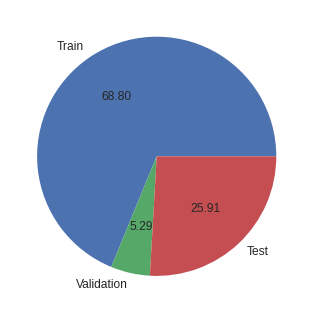

In [7]:
train_examples = dataset['train'].num_rows
val_examples = dataset['validation'].num_rows
test_examples = dataset['test'].num_rows

plt.pie([train_examples, val_examples, test_examples], labels=['Train', 'Validation', 'Test'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

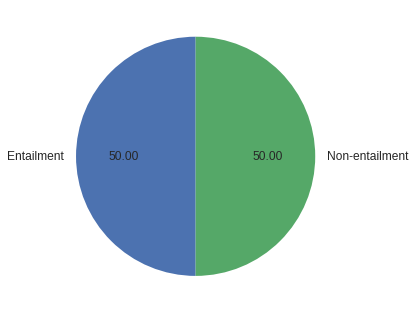

In [8]:
def count_pos_and_neg():
    pos = 0,
    neg = 0
    for key in dataset.keys():
        partial_neg, partial_pos = np.bincount(dataset[key]['entailment_judgment'])
        pos += partial_pos
        neg += int(partial_neg)

    return int(pos), neg

pos, neg = count_pos_and_neg()
plt.pie([pos, neg], labels=['Entailment', 'Non-entailment'], autopct='%.2f', textprops={'size': 'large'}, startangle=90)
plt.show()

# Pre-processamento

In [9]:
def get_related_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def normalize_relatedness_score(examples):
    scores = np.array(examples['relatedness_score'])
    return {'label': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0]}

In [35]:
model_name = 'multi'
check_model(model_name)

tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name], model_max_length=train_examples)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

encoded_dataset = dataset.map(encoder, batched=True)

check_task()
if TASK == 'sts':
    scaler = MinMaxScaler()
    scores = get_related_scores()
    scaler.fit(scores.reshape(-1, 1))
    encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
else:
    encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)

pre_encoder_columns = set(dataset["train"].features)
encoder_columns = list(set(encoded_dataset["train"].features) - pre_encoder_columns)

print("\nColumns added after preprocessing:", encoder_columns)


Columns added after preprocessing: ['input_ids', 'label', 'attention_mask', 'token_type_ids']


# Fine-tuning

In [38]:
class Metric:
    def __init__(self, name):
        self.metric_name = name
        self.func = load(self.metric_name)

    def callback(self, eval_dataset):
        return KerasMetricCallback(metric_fn=self.compute, eval_dataset=eval_dataset)
        
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions

        predictions = np.argmax(predictions, axis=1)

        compute_func = self.func.compute(predictions=predictions, references=labels)

        if self.metric_name in ('precision', 'recall'):
            compute_func = self.func.compute(predictions=predictions, references=labels, zero_division=0)
          
        return compute_func

def load_metrics(validation_set, metrics=None):
    if not metrics:
        if TASK == 'sts': 
            metrics = ['pearsonr']

        elif TASK == 'rte':
            metrics = ['accuracy', 'f1']
    
    metrics_callbacks = []
    for name in metrics:
        callback = Metric(name).callback(validation_set)
        metrics_callbacks.append(callback)

In [39]:
def load_model(model_name):
    from_pt = True if model_name == MODELS["b-large"] else False

    if TASK == 'sts':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=from_pt)
        
        model.compile(
                optimizer='adam',
                loss='mse',
        )
        

    elif TASK == 'rte':        
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)
        
        model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
        )
        
    return model

In [18]:
model = load_model(MODELS[model_name])
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 177,854,978
Trainable params: 177,854,978
Non-trainable params: 0
_________________________________________________________________


In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_set = model.prepare_tf_dataset(
    encoded_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    encoded_dataset["validation"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [40]:
metrics_callback = load_metrics(tf_validation_set)
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=metrics_callback)

Epoch 1/2


KeyboardInterrupt: ignored

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

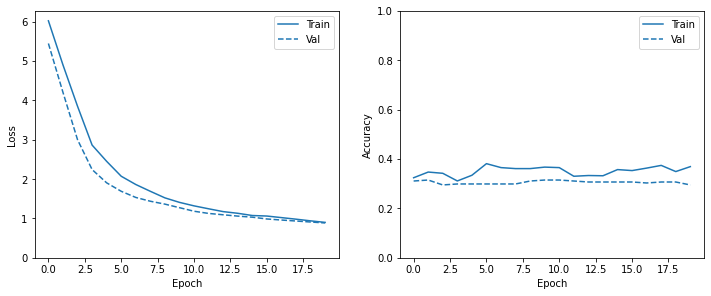

In [ ]:
plot_metrics(history, metrics=model.metrics_names)

In [ ]:
results = model.evaluate(tf_test_dataset.batch(20), batch_size=2048, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.8500600457191467
accuracy :  0.26618704199790955



Legitimate Transactions Detected (True Negatives):  11
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  97
Fraudulent Transactions Detected (True Positives):  26
Total Fraudulent Transactions:  123


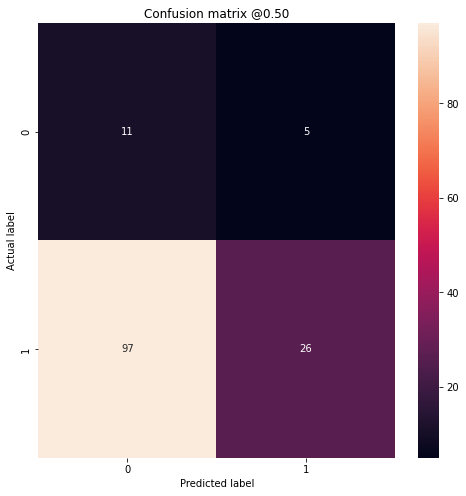

In [ ]:
test_sentences = test_dataset['text'].values.tolist()
encodings = tokenizer(test_sentences, truncation=True, padding='longest', return_tensors="np")
outputs = model(encodings).logits

y = test_dataset['label'].values.tolist()
y_hat = np.argmax(outputs, axis=1)

plot_confusion_matrix(y, y_hat)